In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
import os
import numpy as np
from tensorflow.image import resize_with_pad, grayscale_to_rgb
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential

PATH = "/mnt/d/Datasets/mini-DDSM/"
imgPATH = PATH + "MINI-DDSM-Complete-PNG-16/"
roi_path = PATH + "ROI/"
data_path = PATH + "fullimg/"
save_dir = "/home/jj/FYP/Models/"
image_size = 224
batch_size = 32

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'

2023-02-03 07:19:20.763757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 07:19:20.771391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 07:19:20.771427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_path,
  # data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_path,
  # data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size)

2023-02-03 07:19:20.840116: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2830 files belonging to 2 classes.
Using 2264 files for training.
Found 2830 files belonging to 2 classes.
Using 566 files for validation.


2023-02-03 07:19:20.841148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 07:19:20.841201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 07:19:20.841217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 07:19:21.258343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-03 07:19:21.258417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not op

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_aug = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds.prefetch(buffer_size=AUTOTUNE)

In [4]:
preprocessing = preprocess_input
pre_trained = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
pre_trained.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.),fill_mode="reflect"),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="reflect"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="reflect")
  ])
#Define model architect
tfinput = Input(shape=(image_size,image_size,3) )
data_augment = data_augmentation(tfinput)
pre_process = preprocessing(data_augment)
resnet50_model=pre_trained(pre_process,training=False)
flatten = tf.keras.layers.GlobalAveragePooling2D()(resnet50_model)
DO1 = Dropout(0.8)(flatten)
Dense1 = Dense(1024,activation = 'relu')(DO1)
x=Dropout(0.7)(Dense1)
x = Dense(512,activation='relu')(x)
DO2 = Dropout(0.7)(x)
output = Dense(1, activation="sigmoid")(DO2)
model = Model(tfinput,output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [5]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/ResNet50/dense_init_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

Epoch 1/10


2023-02-03 07:19:25.494634: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


 3/71 [>.............................] - ETA: 4s - loss: 2.7236 - binary_accuracy: 0.5000 - false_positives: 32.0000 - false_negatives: 16.0000

2023-02-03 07:19:27.681692: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-03 07:19:27.681737: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-03 07:19:27.695934: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-03 07:19:27.695989: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

71/71 [==============================] - ETA: 0s - loss: 1.8953 - binary_accuracy: 0.5102 - false_positives: 572.0000 - false_negatives: 537.0000

2023-02-03 07:20:08.301912: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-03 07:20:08.301965: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-03 07:20:08.314207: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-03 07:20:08.314246: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc


Epoch 1: val_binary_accuracy improved from -inf to 0.55477, saving model to /home/jj/FYP/Checkpoint/ResNet50/dense_init_checkpoint/cp-0001.ckpt


2023-02-03 07:20:27.052078: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-03 07:20:27.052127: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


71/71 [==============================] - 65s 852ms/step - loss: 1.8953 - binary_accuracy: 0.5102 - false_positives: 572.0000 - false_negatives: 537.0000 - val_loss: 0.6940 - val_binary_accuracy: 0.5548 - val_false_positives: 18.0000 - val_false_negatives: 234.0000
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 1.6806 - binary_accuracy: 0.4934 - false_positives: 574.0000 - false_negatives: 573.0000
Epoch 2: val_binary_accuracy improved from 0.55477 to 0.60601, saving model to /home/jj/FYP/Checkpoint/ResNet50/dense_init_checkpoint/cp-0002.ckpt
71/71 [==============================] - 6s 87ms/step - loss: 1.6806 - binary_accuracy: 0.4934 - false_positives: 574.0000 - false_negatives: 573.0000 - val_loss: 0.6590 - val_binary_accuracy: 0.6060 - val_false_positives: 34.0000 - val_false_negatives: 189.0000
Epoch 3/10
70/71 [============================>.] - ETA: 0s - loss: 1.5153 - binary_accuracy: 0.5165 - false_positives: 543.0000 - false_negatives: 540.0000
Epoch 3: va

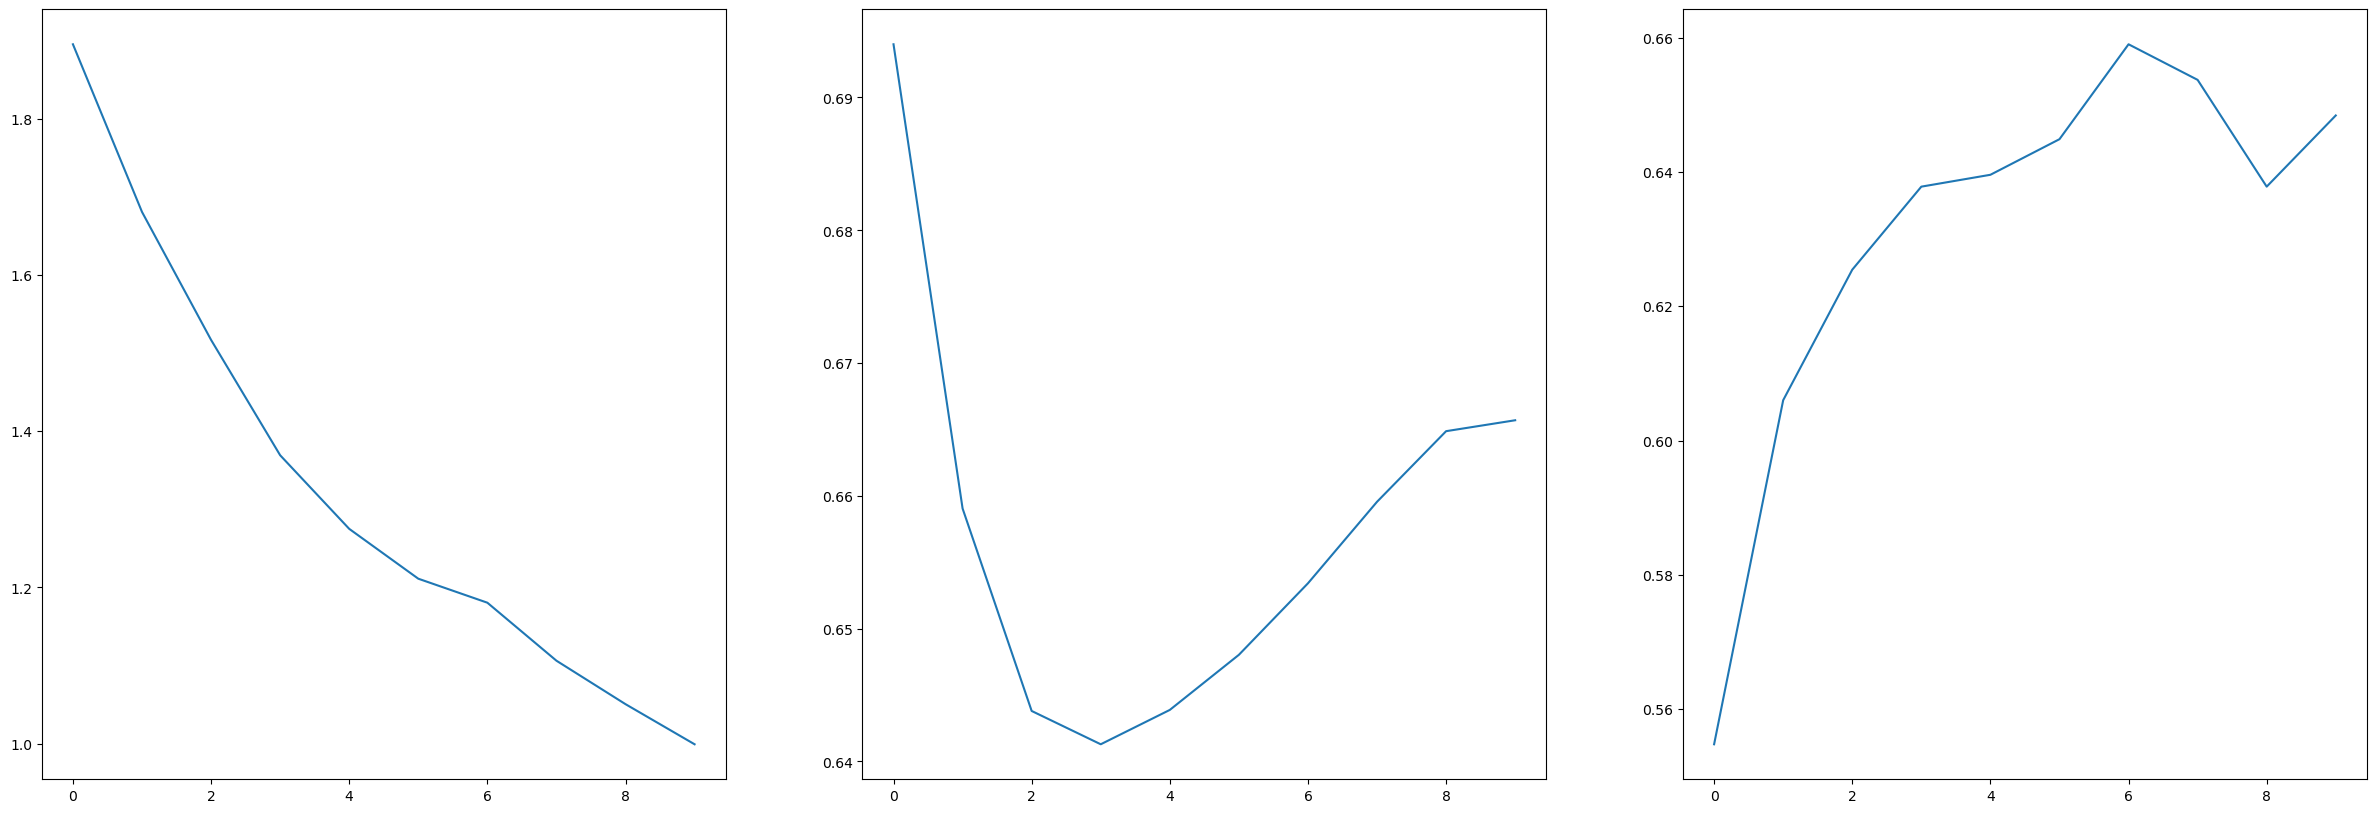

In [6]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
total_epochs = 10
dense_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(dense_init.history['loss'])
plt.subplot(132)
plt.plot(dense_init.history['val_loss'])
plt.subplot(133)
plt.plot(dense_init.history['val_binary_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

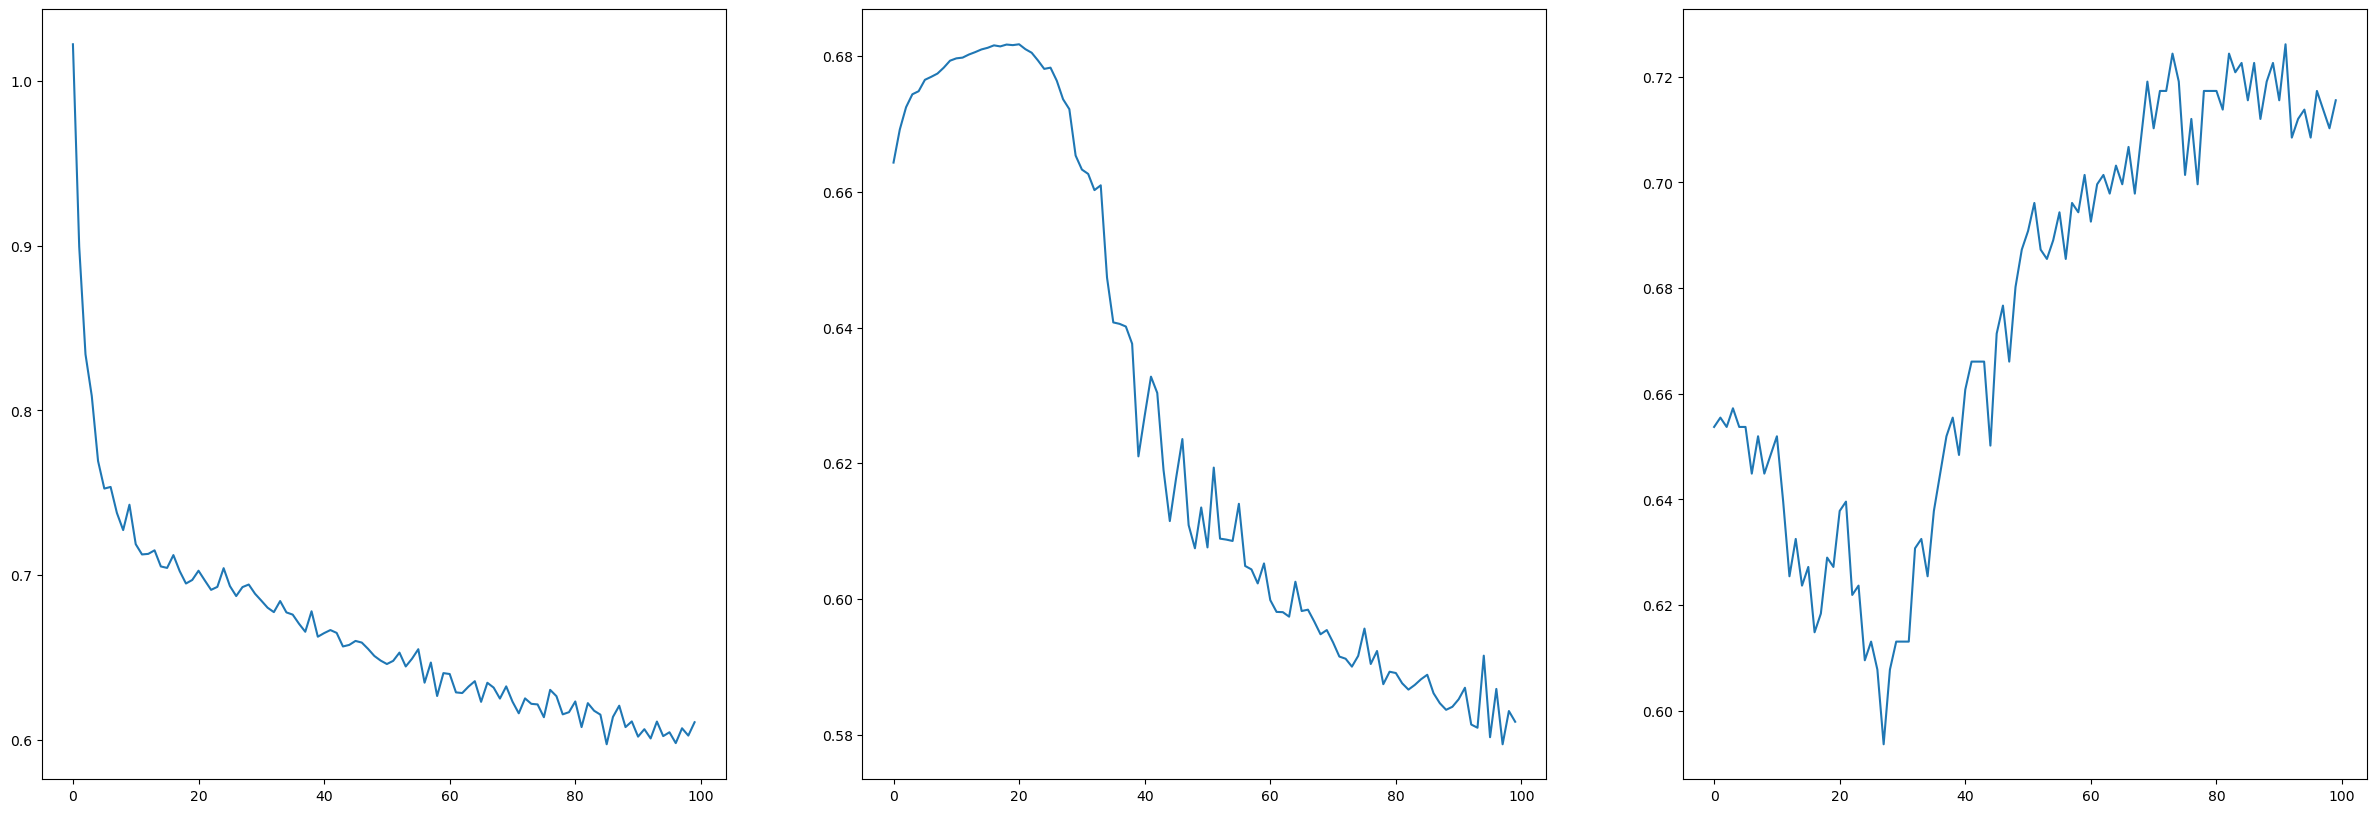

: 

In [8]:
#load model with best performance
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/ResNet50/dense_init_checkpoint/')
model.load_weights(latest)
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-22]:
  layer.trainable = False
init_lr = 1e-5
steps = 10000
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.Adam(lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/ResNet50/fine_tuning_checkpoint_loss_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/ResNet50/fine_tuning_checkpoint_acc_2/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])